In [1]:
import matplotlib.pyplot as plt

import numpy as np
from skimage import io
from skimage.transform import AffineTransform
from skimage.measure import ransac
from skimage.color import rgb2gray, rgba2rgb
from skimage.feature import match_descriptors, plot_matches, SIFT
import cv2


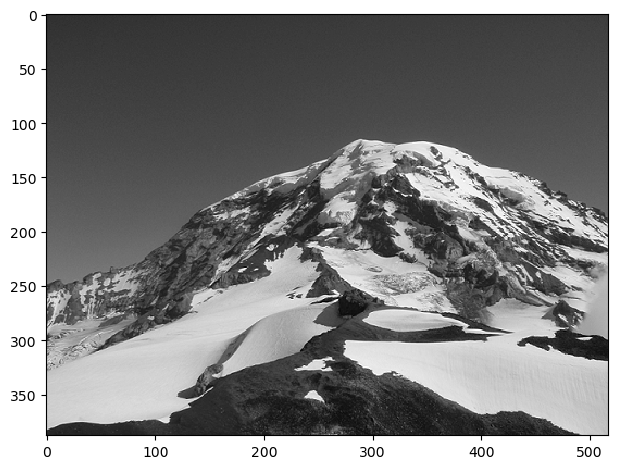

In [2]:
#load the image, and convert it to gray image
img1 = cv2.imread('data/Rainier1.png')
#openCV read image using BGR color space, convert it back to show original image
img1_RGB = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

io.imshow(img1_gray)


[ WARN:0@0.236] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_506zufg7xt/croots/recipe/opencv-suite_1664548331847/work/opencv_contrib-4.6.0/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


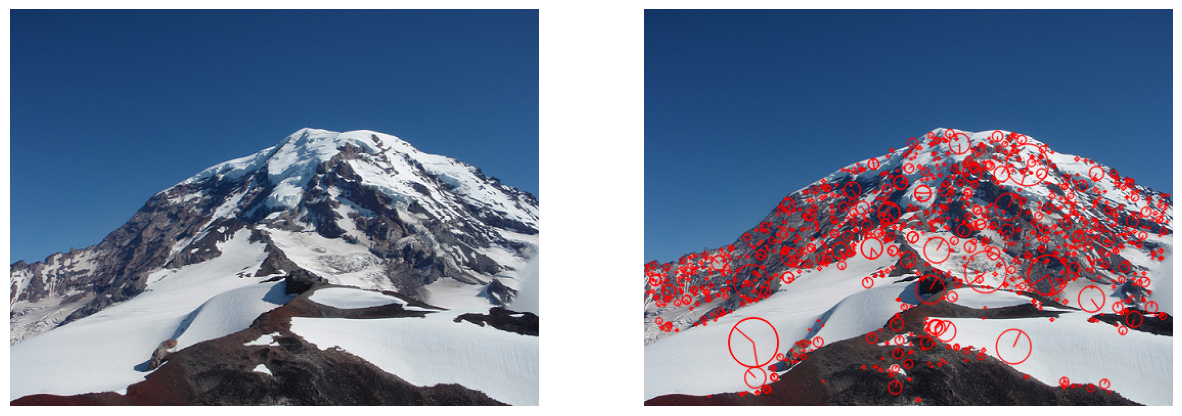

In [3]:
def extract_keypoints(img_gray):
    #create sift object
    sift = cv2.xfeatures2d.SIFT_create()
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)
    
    return keypoints, descriptors

keypoints1, descriptors1 = extract_keypoints(img1_gray)

# Draw keypoints on the image
img1_keypoints = cv2.drawKeypoints(img1_RGB, keypoints1, None, color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display original image next to image with keypoints
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].imshow(img1_RGB)
ax[0].axis('off')
ax[1].imshow(img1_keypoints)
ax[1].axis('off')
plt.show()

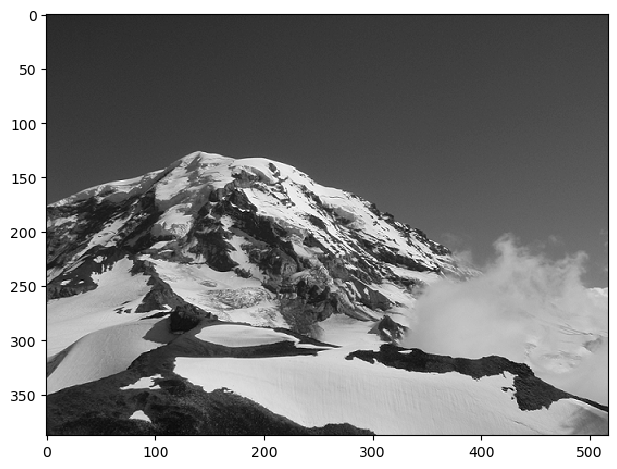

In [4]:
#load the image, and convert it to gray image
img2 = cv2.imread('data/Rainier2.png')
#openCV read image using BGR color space, convert it back to show original image
img2_RGB = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

io.imshow(img2_gray)

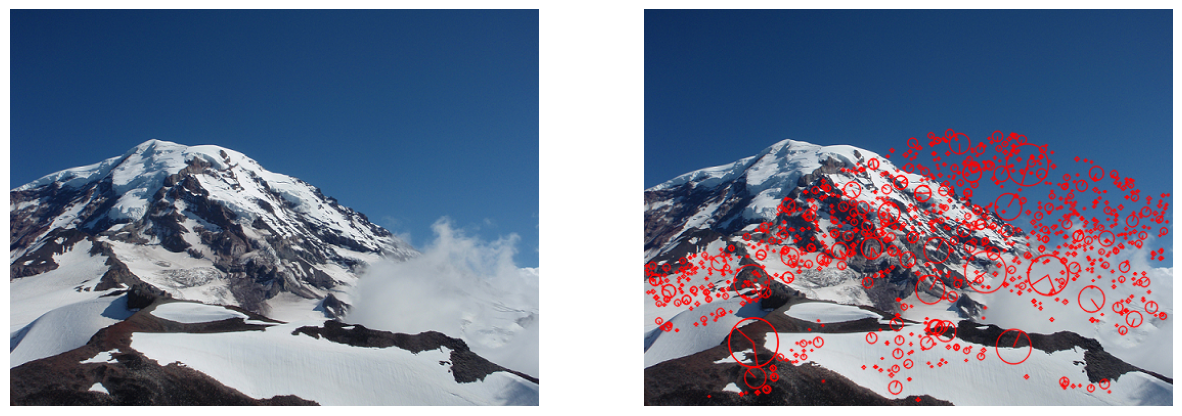

In [5]:
keypoints2, descriptors2 = extract_keypoints(img2_gray)

# Draw keypoints on the image
img2_keypoints = cv2.drawKeypoints(img2_RGB, keypoints1, None, color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display original image next to image with keypoints
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
ax[0].imshow(img2_RGB)
ax[0].axis('off')
ax[1].imshow(img2_keypoints)
ax[1].axis('off')
plt.show()

In [6]:
#print(descriptors1.shape)
#print(descriptors2.shape)
def match_keypoints(dc1, dc2, ratio):
    matching_list = []
   
    for i in range(len(dc1)):
        #init the closest and the second closest distance
        first_distance = np.linalg.norm(dc1[i] - dc2[0])
        second_distance = np.linalg.norm(dc1[i] - dc2[1])
        if first_distance < second_distance:
            min_distance = first_distance
            second_min_distance = second_distance
            match_pos = [i,0]
        else:
            min_distance = second_distance
            second_min_distance = first_distance
            match_pos = [i,1]
            
        # loop through the features vector in the second image
        for j in range(2,len(dc2)):
            L2_norm = np.linalg.norm(dc1[i] - dc2[j])
            #updates distances
            if L2_norm < min_distance:
                second_min_distance = min_distance
                min_distance = L2_norm
                match_pos = [i,j]
        #filter matching points with the lowe's ratio
        if min_distance/second_min_distance < ratio:
            matching_list.append(match_pos)
        
    return matching_list

matching_list = match_keypoints(descriptors1, descriptors2, 0.8)
            

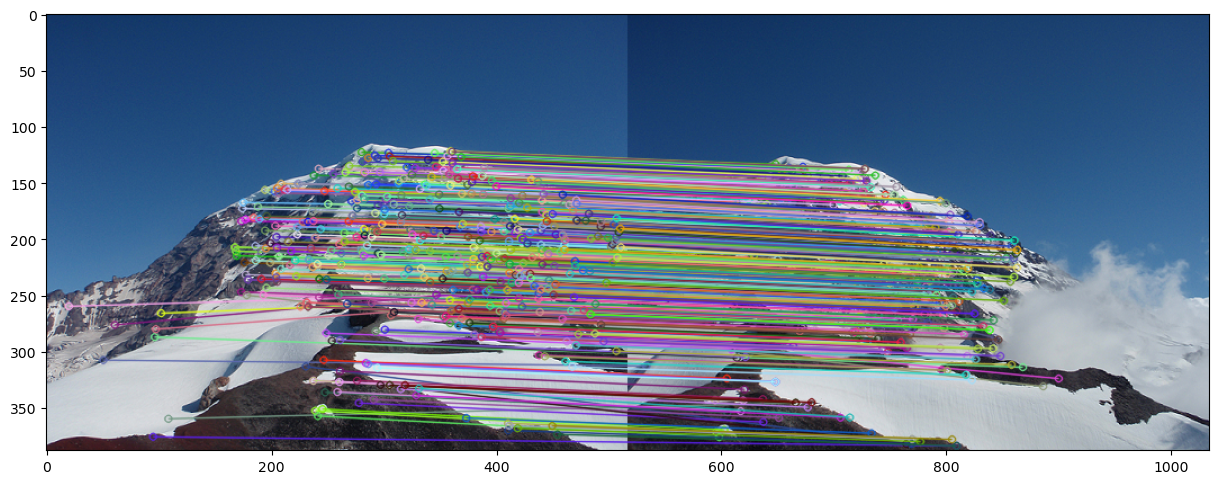

In [7]:
#using openCV to draw match first

# Match keypoints using BFMatcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)
# print(matches[0])
# print(keypoints1[0])
# print(descriptors1[0])

# Filter matches using the Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good_matches.append(m)
# Draw matches and show the results
result = cv2.drawMatches(img1_RGB, keypoints1, img2_RGB, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig, ax = plt.subplots(figsize=(15,7))
ax.imshow(result)


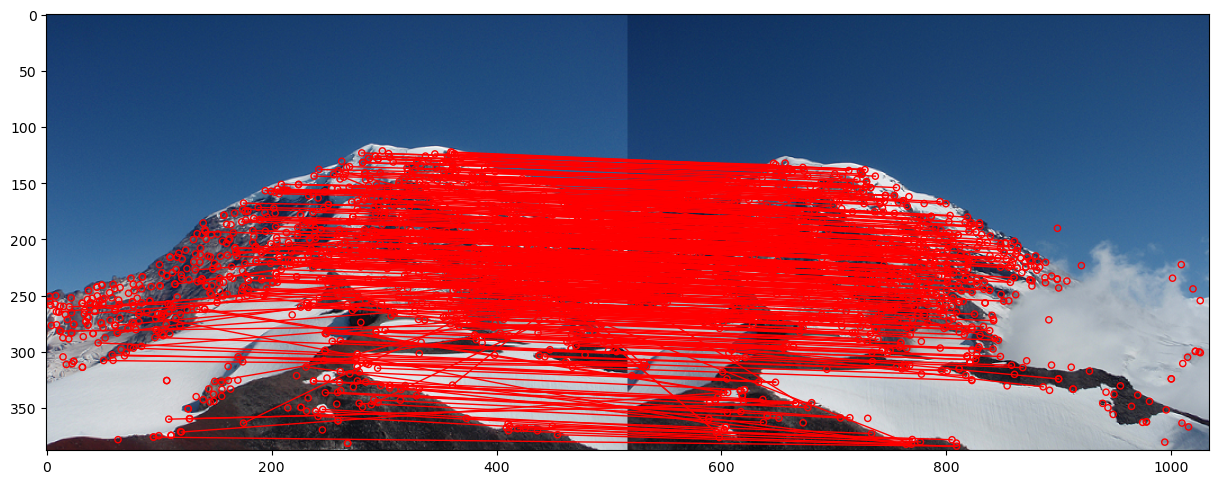

In [8]:
#print(np.array(keypoints1).shape)
#print(descriptors1.shape)
#print(keypoints1[0].pt)
def plot_matched_keypoints(matching_list, img1, kp1, img2, kp2):
    # Create a figure with two img

    fig, ax = plt.subplots(figsize = (15,7))
    ax.imshow(np.hstack((img1, img2)))
    ax.scatter([kp.pt[0] for kp in kp1], [kp.pt[1] for kp in kp1],facecolor='none', edgecolor='r', s=20)
    ax.scatter([kp.pt[0]+img1.shape[1] for kp in kp2], [kp.pt[1] for kp in kp2],facecolor='none', edgecolor='r', s=20)
    
    # Plot lines between matching keypoints
    for m in matching_list:
        #idx of the feature vector
        idx1 = m[0]
        idx2 = m[1]
        x1, y1 = kp1[idx1].pt
        x2, y2 = kp2[idx2].pt + np.array([img1.shape[1], 0])
        ax.plot([x1, x2], [y1, y2], color='red', linewidth=1)
    
    plt.show()

plot_matched_keypoints(matching_list, img1_RGB, keypoints1, img2_RGB, keypoints2)